In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import copy

import torch.optim as optim
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.models as models


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Task 0.1

In [13]:
batch_size = 32

# Download the dataset and create the dataloaders
cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=transforms.ToTensor())

##YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##
generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(cifar_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(cifar_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, num_workers=2)

cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


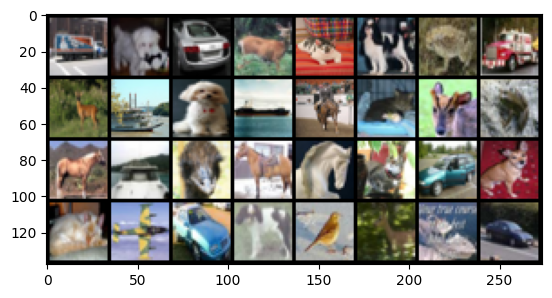

truck dog   car   deer  cat   dog   frog  truck deer  ship  dog   ship  horse cat   deer  frog  horse ship  bird  horse horse cat   car   dog   cat   plane car   dog   bird  deer  ship  car  


In [56]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels (from previous layer), 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully connected layer with 16x5x5 input features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer with 10 classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Apply first convolution, ReLU activation, and max pooling
        # print("first pool",x.shape)
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Apply second convolution, ReLU activation, and max pooling
        # print("second pool",x.shape)
        # Flatten the feature maps for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = F.leaky_relu(self.fc2(x))  # Apply first fully connected layer with ReLU activation
        x = self.fc3(x)  # Apply output layer (no activation for binary classification)

        return x

In [58]:
writer = SummaryWriter()

In [60]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    """
    Trains the given model using the specified data loaders.

    Args:
        model (nn.Module): The neural network model to train.
        criterion: Loss function (e.g., nn.CrossEntropyLoss for classification).
        optimizer: Optimizer (e.g., Adam, SGD) for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs (int): Number of training epochs.

    Returns:
        None
    """
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            # inputs_aug = transform(inputs)
            inputs_aug = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # tensorboard
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(model, criterion, test_loader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    correct = 0

    y_pred = []
    y_true = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            y_true.extend(labels)
#             inputs_aug = transform(inputs).to(device)
            inputs_aug = inputs.to(device)
            outputs = model(inputs_aug)
            labels = labels.to(device)
            # pred = torch.argmax(outputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            y_pred.extend(predicted)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    correct = correct /len(test_loader.dataset)
    print(f"Validation set Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    y_pred_cpu = [yp.cpu() for yp in y_pred]
    cm = confusion_matrix(y_true, y_pred_cpu)
    ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=classes).plot()
    return test_loss, correct

In [70]:
LEARNING_RATE = 1e-4
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


# Load our network
model = Net()

# Define our loss function
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-5)
# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, vali_loader, 50)
writer.flush()

Epoch [1/50] - Train Loss: 2.0468 - Val Loss: 1.8857
Epoch [2/50] - Train Loss: 1.8013 - Val Loss: 1.7271
Epoch [3/50] - Train Loss: 1.6965 - Val Loss: 1.6743
Epoch [4/50] - Train Loss: 1.6396 - Val Loss: 1.6018
Epoch [5/50] - Train Loss: 1.6009 - Val Loss: 1.5723
Epoch [6/50] - Train Loss: 1.5678 - Val Loss: 1.5432
Epoch [7/50] - Train Loss: 1.5367 - Val Loss: 1.5178
Epoch [8/50] - Train Loss: 1.5096 - Val Loss: 1.4841
Epoch [9/50] - Train Loss: 1.4835 - Val Loss: 1.4574
Epoch [10/50] - Train Loss: 1.4580 - Val Loss: 1.4239
Epoch [11/50] - Train Loss: 1.4386 - Val Loss: 1.4071
Epoch [12/50] - Train Loss: 1.4187 - Val Loss: 1.3871
Epoch [13/50] - Train Loss: 1.3999 - Val Loss: 1.3727
Epoch [14/50] - Train Loss: 1.3859 - Val Loss: 1.3645
Epoch [15/50] - Train Loss: 1.3706 - Val Loss: 1.3447
Epoch [16/50] - Train Loss: 1.3537 - Val Loss: 1.3245
Epoch [17/50] - Train Loss: 1.3373 - Val Loss: 1.3007
Epoch [18/50] - Train Loss: 1.3243 - Val Loss: 1.3019
Epoch [19/50] - Train Loss: 1.3088 - 

In [67]:
# from torchvision.transforms import v2

%reload_ext tensorboard

%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 785), started 0:02:28 ago. (Use '!kill 785' to kill it.)

Validation set Error: 
 Accuracy: 58.3%, Avg loss: 1.188379 



(1.1883790258782359, 0.5826)

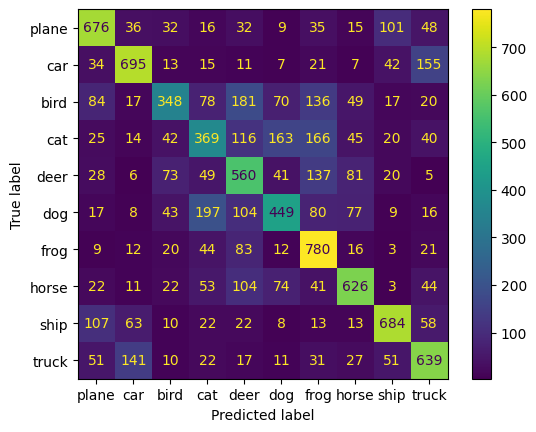

In [73]:
test(model, criterion, test_loader)

In [74]:
# prepare to count predictions for each class
#  refer to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.6 %
Accuracy for class: car   is 69.5 %
Accuracy for class: bird  is 34.8 %
Accuracy for class: cat   is 36.9 %
Accuracy for class: deer  is 56.0 %
Accuracy for class: dog   is 44.9 %
Accuracy for class: frog  is 78.0 %
Accuracy for class: horse is 62.6 %
Accuracy for class: ship  is 68.4 %
Accuracy for class: truck is 63.9 %


# Task 0.2

# Task 0.2.2  Transfer Learning from MNIST

• Download and prepare CIFAR-10 dataset (it is already available in the above mentioned
libraries)
• Use AlexNet as the model (Pytorch AlexNet)
• You have to perform two separate experiments-
– Train the model for CIFAR-10 data, Report the test test accuracy. (also referred as ﬁne
tuning the model)
– Use the pretarined weights of AlexNet, in other words use AlexNet as a pretrained
network for image classiﬁcation on CIFAR-10 data (also referred as Feature Extraction),
Report the test test accuracy. (optional)
• In both the above cases remember to add an extra fully connected layer to the classiﬁer with
number of neurons = 10, because there are 10 classes in CIFAR-10 dataset. This layer will
be trainable in both cases.
• Explain (brieﬂy!) what is the diﬀerence between the two runs and why there is a diﬀerence
in performance. (optional)

– Train the model for CIFAR-10 data, Report the test test accuracy. (also referred as ﬁne
tuning the model)

In [139]:
# Fine-tune a model to the dataset
# We use AlexNet as the model.
model_ft = models.alexnet()

# Do the things required for fine-tuning before training the model
# for param in model_ft.parameters():
#     param.requires_grad = False

num_class = 10
new_classifier = nn.Sequential(
    *list(model_ft.classifier.children()), 
    nn.Linear(1000, num_class)  # new last layer with 10 outputs
)

# Modify the classifier
model_ft.classifier = new_classifier
# resize image
target_size = (128, 128)
transform = transforms.Compose([
    transforms.Resize(target_size)
])
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [127]:
def train_model_transf(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    """
    Trains the given model using the specified data loaders.

    Args:
        model (nn.Module): The neural network model to train.
        criterion: Loss function (e.g., nn.CrossEntropyLoss for classification).
        optimizer: Optimizer (e.g., Adam, SGD) for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs (int): Number of training epochs.

    Returns:
        None
    """
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            inputs_aug = transform(inputs).to(device)
            # inputs_aug = inputs
            labels = labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # tensorboard
#         writer.add_scalar("Loss/train", avg_train_loss, epoch)
        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:
                inputs_aug = transform(inputs).to(device)
                labels = labels.to(device)
                outputs = model(inputs_aug)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [140]:
# Train the model
optimizer_task2 = optim.Adam(model_ft.parameters(), lr=1e-4, weight_decay = 1e-5)
trained_model_ft = train_model_transf(model_ft, criterion, optimizer_task2, train_loader, vali_loader, 15, device)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/15] - Train Loss: 1.6573 - Val Loss: 1.3169
Epoch [2/15] - Train Loss: 1.1820 - Val Loss: 1.0418
Epoch [3/15] - Train Loss: 0.9745 - Val Loss: 0.8195
Epoch [4/15] - Train Loss: 0.8272 - Val Loss: 0.7248
Epoch [5/15] - Train Loss: 0.7028 - Val Loss: 0.6056
Epoch [6/15] - Train Loss: 0.6001 - Val Loss: 0.5064
Epoch [7/15] - Train Loss: 0.5099 - Val Loss: 0.4234
Epoch [8/15] - Train Loss: 0.4265 - Val Loss: 0.3774
Epoch [9/15] - Train Loss: 0.3506 - Val Loss: 0.3205
Epoch [10/15] - Train Loss: 0.2841 - Val Loss: 0.3080
Epoch [11/15] - Train Loss: 0.2370 - Val Loss: 0.2687
Epoch [12/15] - Train Loss: 0.2002 - Val Loss: 0.2742
Epoch [13/15] - Train Loss: 0.1787 - Val Loss: 0.2610
Epoch [14/15] - Train Loss: 0.1485 - Val Loss: 0.2552
Epoch [15/15] - Train Loss: 0.1314 - Val Loss: 0.2566
Training complete!


In [78]:
def test2(model, criterion, test_loader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    correct = 0

    y_pred = []
    y_true = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            y_true.extend(labels)
            inputs_aug = transform(inputs).to(device)
#             inputs_aug = inputs.to(device)
            outputs = model(inputs_aug)
            labels = labels.to(device)
            # pred = torch.argmax(outputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            y_pred.extend(predicted)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    correct = correct /len(test_loader.dataset)
    print(f"Validation set Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    y_pred_cpu = [yp.cpu() for yp in y_pred]
    cm = confusion_matrix(y_true, y_pred_cpu)
    ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=classes).plot()
    return test_loss, correct

Validation set Error: 
 Accuracy: 75.6%, Avg loss: 1.043799 



(1.0437994377491193, 0.7557)

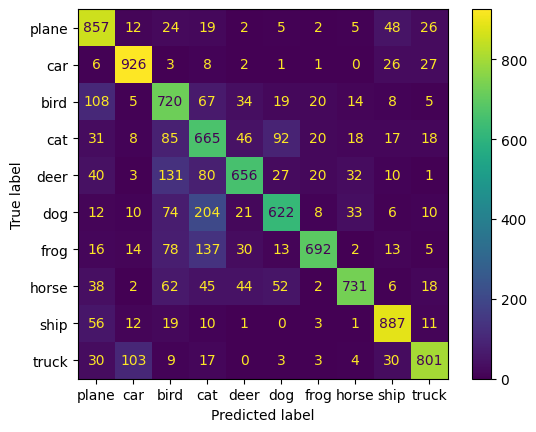

In [142]:
test2(model_ft, criterion, test_loader)

In [143]:
# prepare to count predictions for each class
#  refer to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images_aug = transform(images).to(device)
        labels = labels.to(device)        
        outputs = model_ft(images_aug)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy for class: plane is 85.7 %
Accuracy for class: car   is 92.6 %
Accuracy for class: bird  is 72.0 %
Accuracy for class: cat   is 66.5 %
Accuracy for class: deer  is 65.6 %
Accuracy for class: dog   is 62.2 %
Accuracy for class: frog  is 69.2 %
Accuracy for class: horse is 73.1 %
Accuracy for class: ship  is 88.7 %
Accuracy for class: truck is 80.1 %


– Use the pretarined weights of AlexNet, in other words use AlexNet as a pretrained
network for image classiﬁcation on CIFAR-10 data (also referred as Feature Extraction),
Report the test test accuracy. (optional)

In [131]:
model_pretrained = models.alexnet(pretrained=True)
for param in model_pretrained.parameters():
    param.requires_grad = False
new_classifier = nn.Sequential(
    *list(model_pretrained.classifier.children()), 
    nn.Linear(1000, num_class)  # new last layer with 10 outputs
)

# Modify the classifier
model_pretrained.classifier = new_classifier
model_pretrained

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [132]:
model_pretrained.classifier[6].weight.requires_grad, model_pretrained.classifier[7].weight.requires_grad

(False, True)

In [137]:
# model_pretrained = model_pretrained.to(device)
# Train the model
optimizer_task2 = optim.Adam(model_pretrained.parameters(), lr=1e-4, weight_decay = 1e-5)
trained_model_ft = train_model_transf(model_pretrained, criterion, optimizer_task2, train_loader, vali_loader, 15, device)

Epoch [1/15] - Train Loss: 1.1255 - Val Loss: 0.9917
Epoch [2/15] - Train Loss: 1.0961 - Val Loss: 0.9696
Epoch [3/15] - Train Loss: 1.0836 - Val Loss: 0.9436
Epoch [4/15] - Train Loss: 1.0656 - Val Loss: 0.9412
Epoch [5/15] - Train Loss: 1.0591 - Val Loss: 0.9341
Epoch [6/15] - Train Loss: 1.0501 - Val Loss: 0.9184
Epoch [7/15] - Train Loss: 1.0466 - Val Loss: 0.9152
Epoch [8/15] - Train Loss: 1.0358 - Val Loss: 0.9109
Epoch [9/15] - Train Loss: 1.0311 - Val Loss: 0.9038
Epoch [10/15] - Train Loss: 1.0285 - Val Loss: 0.8947
Epoch [11/15] - Train Loss: 1.0254 - Val Loss: 0.8906
Epoch [12/15] - Train Loss: 1.0225 - Val Loss: 0.8945
Epoch [13/15] - Train Loss: 1.0143 - Val Loss: 0.8891
Epoch [14/15] - Train Loss: 1.0107 - Val Loss: 0.8960
Epoch [15/15] - Train Loss: 1.0078 - Val Loss: 0.8964
Training complete!


Validation set Error: 
 Accuracy: 67.6%, Avg loss: 0.933359 



(0.9333585564511272, 0.6761)

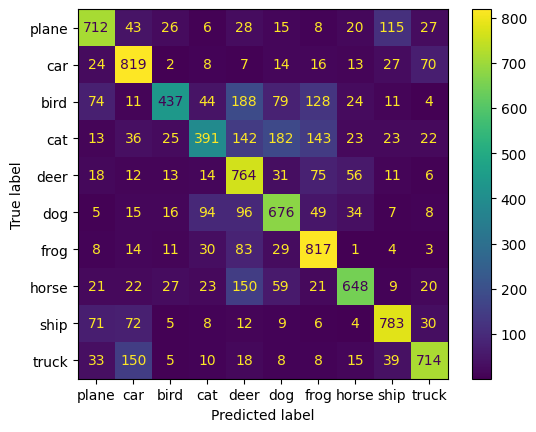

In [138]:
test2(model_pretrained, criterion, test_loader)

In [141]:
# prepare to count predictions for each class
#  refer to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images_aug = transform(images).to(device)
        labels = labels.to(device)        
        outputs = model_pretrained(images_aug)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.2 %
Accuracy for class: car   is 81.9 %
Accuracy for class: bird  is 43.7 %
Accuracy for class: cat   is 39.1 %
Accuracy for class: deer  is 76.4 %
Accuracy for class: dog   is 67.6 %
Accuracy for class: frog  is 81.7 %
Accuracy for class: horse is 64.8 %
Accuracy for class: ship  is 78.3 %
Accuracy for class: truck is 71.4 %


In [ ]:
# • Explain (briey!) what is the difference between the two runs and why there is a difference in performance. (optional)

"""
*when train the Alexnet model, all the parameters/weights are updated while in tranfer learning, the second task, 
it is only training the last layer. Therefore, the first model has better performance/accuracy, i.e. 75.6& VS. 67.6%
*the second task, is much faster.
"""

# Task 0.2.2  Transfer Learning from MNIST

• Prepare a CNN of your choice and train it on the MNIST data. Report the accuracy
• Use the above model as a pre-trained CNN for the SVHN dataset. Report the accuracy
• In the third step you are performing transfer learning from MNIST to SVHN (optional).

In [182]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels (from previous layer), 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully connected layer with 16x5x5 input features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer with 10 classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Apply first convolution, ReLU activation, and max pooling
        # print("first pool",x.shape)
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Apply second convolution, ReLU activation, and max pooling
        # print("second pool",x.shape)
        # Flatten the feature maps for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = F.leaky_relu(self.fc2(x))  # Apply first fully connected layer with ReLU activation
        x = self.fc3(x)  # Apply output layer (no activation for binary classification)

        return x

## Load MNIST

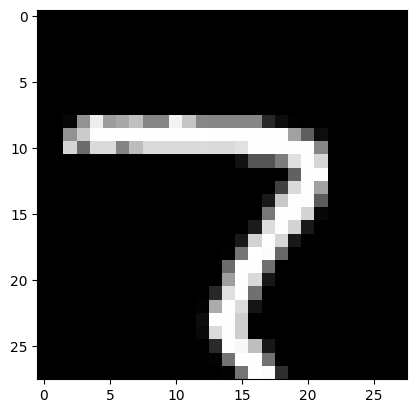

Image shape: torch.Size([1, 28, 28]), Target label: 7


In [183]:
# Define the mini-batch size
batch_size = 64

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())

##YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##
generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)


def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])
print(f"Image shape: {images[0].shape}, Target label: {labels[0]}")

In [179]:
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((32,32))

])
def transform_tensor(inputs):
    # Resize images
    resized_images = torch.nn.functional.interpolate(inputs, size=(32, 32), mode='bilinear', align_corners=False)
    # Replicate channels
    replicated_images = resized_images.repeat(1, 3, 1, 1)  # repeat along the channel dimension
    return replicated_images

In [215]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, transform=False):
    """
    Trains the given model using the specified data loaders.

    Args:
        model (nn.Module): The neural network model to train.
        criterion: Loss function (e.g., nn.CrossEntropyLoss for classification).
        optimizer: Optimizer (e.g., Adam, SGD) for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs (int): Number of training epochs.

    Returns:
        None
    """
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            # inputs_aug = transform(inputs)
            
            labels = labels.to(device)   
            if transform:
                inputs_aug = transform_mnist(inputs).to(device)
            else:
                inputs_aug = transform_tensor(inputs).to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:
                
                if transform:
                    inputs = transform_mnist(inputs).to(device)
                else:
                    inputs = transform_tensor(inputs).to(device)
#                     inputs = transform_tensor(inputs).to(device)
                labels = labels.to(device)  
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [185]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5) # try SGD to see if better accuracy
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
trained_model = train_model(model, criterion, optimizer, train_loader, vali_loader, 30, False)

Epoch [1/30] - Train Loss: 0.8432 - Val Loss: 0.2854
Epoch [2/30] - Train Loss: 0.2290 - Val Loss: 0.1915
Epoch [3/30] - Train Loss: 0.1696 - Val Loss: 0.1541
Epoch [4/30] - Train Loss: 0.1369 - Val Loss: 0.1247
Epoch [5/30] - Train Loss: 0.1169 - Val Loss: 0.1070
Epoch [6/30] - Train Loss: 0.1028 - Val Loss: 0.0906
Epoch [7/30] - Train Loss: 0.0917 - Val Loss: 0.0865
Epoch [8/30] - Train Loss: 0.0843 - Val Loss: 0.0776
Epoch [9/30] - Train Loss: 0.0772 - Val Loss: 0.0711
Epoch [10/30] - Train Loss: 0.0716 - Val Loss: 0.0667
Epoch [11/30] - Train Loss: 0.0671 - Val Loss: 0.0636
Epoch [12/30] - Train Loss: 0.0624 - Val Loss: 0.0595
Epoch [13/30] - Train Loss: 0.0584 - Val Loss: 0.0566
Epoch [14/30] - Train Loss: 0.0544 - Val Loss: 0.0518
Epoch [15/30] - Train Loss: 0.0513 - Val Loss: 0.0515
Epoch [16/30] - Train Loss: 0.0481 - Val Loss: 0.0458
Epoch [17/30] - Train Loss: 0.0466 - Val Loss: 0.0412
Epoch [18/30] - Train Loss: 0.0437 - Val Loss: 0.0402
Epoch [19/30] - Train Loss: 0.0415 - 

In [202]:
classes = ('1', '2', '3', '4',
           '5', '6', '7', '8', '9', '0')
def test3(model, criterion, test_loader, transform=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    correct = 0

    y_pred = []
    y_true = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            y_true.extend(labels)
#             
            inputs_aug = transform_tensor(inputs).to(device)
            if transform:
                inputs_aug = transform_mnist(inputs).to(device)
#             inputs_aug = inputs.to(device)
            outputs = model(inputs_aug)
            labels = labels.to(device)
            # pred = torch.argmax(outputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            y_pred.extend(predicted)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    correct = correct /len(test_loader.dataset)
    print(f"Validation set Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    y_pred_cpu = [yp.cpu() for yp in y_pred]
    cm = confusion_matrix(y_true, y_pred_cpu)
    ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=classes).plot()
    return test_loss, correct

Validation set Error: 
 Accuracy: 98.7%, Avg loss: 0.038075 



(0.03807490576909218, 0.9869)

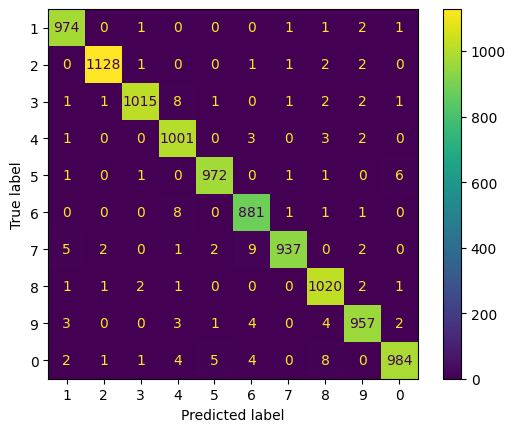

In [203]:
test3(model, criterion, test_loader,False)

# Load SVHN dataset

In [188]:
svhn_train = datasets.SVHN("./", download=True, transform=transforms.ToTensor())
generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(svhn_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(svhn_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False)


Using downloaded and verified file: ./train_32x32.mat


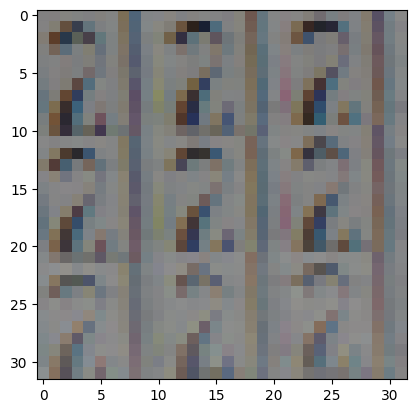

Image shape: torch.Size([3, 32, 32]), Target label: 2


In [204]:
images, labels = next(iter(train_loader))
data = images[0].view(32, 32, 3)
plt.imshow(data)
plt.show()
print(f"Image shape: {images[0].shape}, Target label: {labels[0]}")

Validation set Error: 
 Accuracy: 16.2%, Avg loss: 4.440404 



(4.440404345374961, 0.16223041223041224)

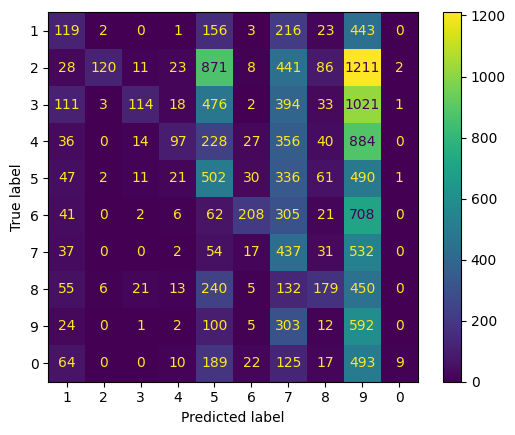

In [205]:
test3(model, criterion, vali_loader, True)

##### 

In [206]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [213]:
# Freeze all layers by disabling gradient computation
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the last two fully connected layers
for param in model.fc2.parameters():
    param.requires_grad = True

for param in model.fc3.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam([
    {'params': model.fc2.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
    {'params': model.fc3.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5}
], lr=1e-3, weight_decay = 1e-5) 


In [216]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
trained_model = train_model(model, criterion, optimizer, train_loader, vali_loader, 15, True)


Epoch [1/15] - Train Loss: 1.4118 - Val Loss: 1.3656
Epoch [2/15] - Train Loss: 1.3268 - Val Loss: 1.2927
Epoch [3/15] - Train Loss: 1.2631 - Val Loss: 1.2364
Epoch [4/15] - Train Loss: 1.2104 - Val Loss: 1.1882
Epoch [5/15] - Train Loss: 1.1685 - Val Loss: 1.1517
Epoch [6/15] - Train Loss: 1.1314 - Val Loss: 1.1157
Epoch [7/15] - Train Loss: 1.1003 - Val Loss: 1.0886
Epoch [8/15] - Train Loss: 1.0739 - Val Loss: 1.0633
Epoch [9/15] - Train Loss: 1.0502 - Val Loss: 1.0416
Epoch [10/15] - Train Loss: 1.0286 - Val Loss: 1.0248
Epoch [11/15] - Train Loss: 1.0109 - Val Loss: 1.0066
Epoch [12/15] - Train Loss: 0.9943 - Val Loss: 0.9937
Epoch [13/15] - Train Loss: 0.9794 - Val Loss: 0.9773
Epoch [14/15] - Train Loss: 0.9654 - Val Loss: 0.9645
Epoch [15/15] - Train Loss: 0.9541 - Val Loss: 0.9559
Training complete!


Validation set Error: 
 Accuracy: 72.3%, Avg loss: 0.955880 



(0.9558803689011319, 0.7233142233142233)

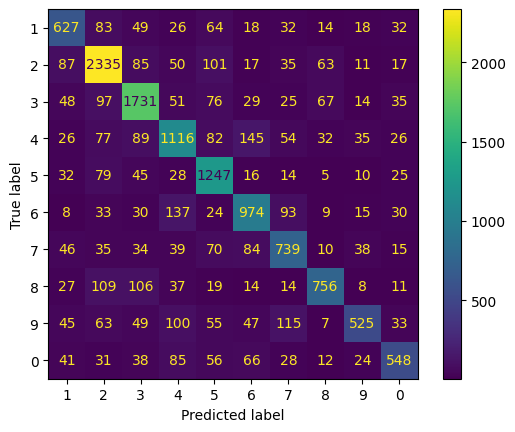

In [217]:
test3(model, criterion, vali_loader, True)